In [1]:
import matplotlib.pyplot as plt
import wisc_ecephys_tools as wet
import xarray as xr
from ecephys import plot as eplt
from ecephys import wne

from findlay2025a import core, plotting, sharp_waves
from findlay2025a.constants import Experiments as Exps

In [6]:
sglx_subject = wet.get_sglx_subject("CNPIX4-Doppio")
experiment = Exps.NOD

nb = core.get_project("seahorse")
s3 = core.get_project("shared")

hg = wne.utils.load_raw_float_hypnogram(
    s3, experiment, sglx_subject.name, simplify=True
)
delta = xr.open_dataarray(
    core.get_cortical_bandpower_file(sglx_subject.name, experiment, "delta")
)
light_dark_periods, light_dark_period_labels = wet.shared.get_light_dark_periods(
    experiment, sglx_subject
)
bslp_start = light_dark_periods[0][0]
bslp_end = 64000  # Doppio CX has issues after this time
is_nrem = hg.keep_states(["NREM"]).covers_time(delta.time)
is_bsl = (delta.time >= bslp_start) & (delta.time <= bslp_end)
bsl_nrem_delta_mean = delta.sel(time=(is_nrem & is_bsl)).mean()
delta = (delta / bsl_nrem_delta_mean) * 100
spws = sharp_waves.read_spws(sglx_subject.name, experiment)
sg = xr.load_dataarray(
    nb.get_experiment_subject_file(experiment, sglx_subject.name, "slow_gamma.nc")
)
fg = xr.load_dataarray(
    nb.get_experiment_subject_file(experiment, sglx_subject.name, "fast_gamma.nc")
)
sgfg = sg / fg
slm_sgfg = sgfg.sel(channel=(sgfg["roi"] == "CA1-slm"))

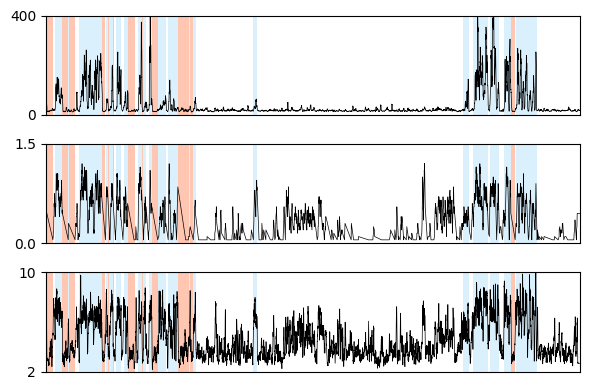

In [10]:
def plot_timetrace(
    da: xr.DataArray, ax: plt.Axes, ylabel: str = None, smoothing: int = 0
):
    if smoothing:
        da = da.rolling(time=smoothing).mean()
    da.plot.line(x="time", color="black", linewidth=0.5, ax=ax, add_legend=False)
    ax.set(xlabel=None, ylabel=ylabel, xmargin=0, xticks=[])


fig, axes = plt.subplots(3, 1, figsize=(6, 4))

plotting.plot_swa_timetrace(delta, axes[0], smoothing=10)
axes[0].set_ylim(0, 400)
axes[0].set_yticks([0, 400])

plotting.plot_event_rate_timetrace(spws, axes[1])
axes[1].set_ylim(0, 1.5)
axes[1].set_yticks([0, 1.5])

plot_timetrace(slm_sgfg, ax=axes[2], ylabel="Slow:Fast Gamma Ratio", smoothing=20)
axes[2].set_ylim(2, 10)
axes[2].set_yticks([2, 10])
axes[2].set_title(None)

for ax in axes:
    ax.set_ylabel(None)
    ax.set_xlim((53200, 64000))
    eplt.plot_hypnogram_overlay(hg, ax=ax, state_colors=eplt.publication_colors)
plt.tight_layout()

# fig.savefig(nb.get_project_file('figures/sgfg_trace_sample.svg'), bbox_inches='tight')
# fig.savefig(nb.get_project_file('figures/sgfg_trace_sample.png'), dpi=600, bbox_inches='tight')